In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Load data

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fileURL = "https://drive.google.com/open?id=1DdYNXjLQZEp9NBvg8y20eBZCyLL5ljWl"
csvHeaders = ["match_id", "account_id", "player_slot", "hero_id", "item_0", "item_1", 
              "item_2", "item_3", "item_4", "item_5", "backpack_0", "backpack_1", "backpack_2",
              "kills", "deaths", "assists", "leaver_status", "gold", "last_hits", "denies", 
              "gold_per_min", "xp_per_min", "gold_spent", "hero_damage", "tower_damage", 
              "hero_healing", "level", "stuns", "obs_placed", "sen_placed", "creeps_stacked",
              "camps_stacked", "rune_pickups", "party_id", "lane", "lane_role", "is_roaming",
              "firstblood_claimed", "teamfight_participation", "towers_killed", "roshans_killed", 
              "observers_placed", "party_size", "match_seq_num", "radiant_win", "start_time",
              "duration", "tower_status_radiant", "tower_status_dire", "barracks_status_radiant",
              "barracks_status_dire", "cluster", "first_blood_time", "lobby_type", "human_players",
              "leagueid", "positive_votes", "negative_votes", "game_mode", "engine", "radiant_score",
              "dire_score", "radiant_team_id", "dire_team_id", "radiant_team_name", "dire_team_name",
              "radiant_team_complete", "dire_team_complete", "radiant_captain", "dire_captain", 
              "version"]
fluff, id = fileURL.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('matches_join_player_matches.csv')  
df = pd.read_csv('matches_join_player_matches.csv', names=csvHeaders, header=None)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
df.head(5)

,match_id,account_id,player_slot,hero_id,item_0,item_1,item_2,item_3,item_4,item_5,backpack_0,backpack_1,backpack_2,kills,deaths,assists,leaver_status,gold,last_hits,denies,gold_per_min,xp_per_min,gold_spent,hero_damage,tower_damage,hero_healing,level,stuns,obs_placed,sen_placed,creeps_stacked,camps_stacked,rune_pickups,party_id,lane,lane_role,is_roaming,firstblood_claimed,teamfight_participation,towers_killed,roshans_killed,observers_placed,party_size,match_seq_num,radiant_win,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire,cluster,first_blood_time,lobby_type,human_players,leagueid,positive_votes,negative_votes,game_mode,engine,radiant_score,dire_score,radiant_team_id,dire_team_id,radiant_team_name,dire_team_name,radiant_team_complete,dire_team_complete,radiant_captain,dire_captain,version
0,1000018815,98134803,2,15,119,110,46,108,116,63,0,0,0,8,5,12,0,NaN,281,36,547,623,NaN,NaN,NaN,NaN,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,895116683,True,1414947750,2764,1972,0,63,32,131,38,1,10,2051,48,8,2,0,0,0,NaN,1839396.0,NaN,NaN,NaN,1.0,93552791.0,87565571.0,20.0
1,1000018815,182993582,130,86,214,60,1,46,73,36,0,0,0,3,15,9,0,NaN,42,3,228,303,NaN,NaN,NaN,NaN,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,895116683,True,1414947750,2764,1972,0,63,32,131,38,1,10,2051,48,8,2,0,0,0,NaN,1839396.0,NaN,NaN,NaN,1.0,93552791.0,87565571.0,20.0
2,1000018815,87219396,129,78,1,0,108,119,63,30,0,0,0,9,6,10,0,NaN,155,8,409,532,NaN,NaN,NaN,NaN,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,895116683,True,1414947750,2764,1972,0,63,32,131,38,1,10,2051,48,8,2,0,0,0,NaN,1839396.0,NaN,NaN,NaN,1.0,93552791.0,87565571.0,20.0
3,1000018815,191422410,1,30,36,214,108,116,46,0,0,0,0,8,8,5,0,NaN,85,2,326,385,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,895116683,True,1414947750,2764,1972,0,63,32,131,38,1,10,2051,48,8,2,0,0,0,NaN,1839396.0,NaN,NaN,NaN,1.0,93552791.0,87565571.0,20.0
4,1000018815,87201671,131,67,185,127,174,147,63,0,0,0,0,4,6,19,0,NaN,187,10,376,514,NaN,NaN,NaN,NaN,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,895116683,True,1414947750,2764,1972,0,63,32,131,38,1,10,2051,48,8,2,0,0,0,NaN,1839396.0,NaN,NaN,NaN,1.0,93552791.0,87565571.0,20.0


## **Hero Clustering**

**Pick interested columns**

In [0]:
data = df[["hero_id", "kills", "deaths", "assists", "gold", "last_hits", "denies", 
           "gold_per_min", "xp_per_min", "gold_spent", "hero_damage", "tower_damage", 
           "hero_healing", "level"]]
# get rid of NaN gold rows
data = data[np.isfinite(data['gold'])]

In [0]:
# check any NaN value
data.isnull().values.any()

False

In [0]:
data.head(5)

,hero_id,kills,deaths,assists,gold,last_hits,denies,gold_per_min,xp_per_min,gold_spent,hero_damage,tower_damage,hero_healing,level
69130,46,1,6,4,1.0,166,25,443,468,10775.0,3554.0,450.0,0.0,16
69131,65,3,4,3,1124.0,90,2,321,299,8550.0,3442.0,0.0,0.0,12
69132,8,5,5,1,1.0,244,22,556,515,16725.0,7750.0,1651.0,0.0,17
69133,17,11,3,8,4393.0,136,7,565,665,13305.0,12643.0,918.0,0.0,19
69134,20,1,3,11,1936.0,27,2,266,344,6045.0,3586.0,131.0,0.0,13


**Aggregate heroes by ID**

In [0]:
hero_data = data.groupby('hero_id').agg({"kills": ["mean"], "deaths": ["mean"], 
                                         "assists": ["mean"], "last_hits": ["mean"], 
                                        "denies": ["mean"], "gold_per_min": ["mean"], 
                                        "xp_per_min": ["mean"], "gold_spent": ["mean"], 
                                        "hero_damage": ["mean"], "tower_damage": ["mean"],
                                        "tower_damage": ["mean"], "level": ["mean"]})
# how many heroes
len(hero_data)

116

In [0]:
hero_data.head()

,kills,deaths,assists,last_hits,denies,gold_per_min,xp_per_min,gold_spent,hero_damage,tower_damage,level
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
hero_id,,,,,,,,,,,
1,6.823423,2.962883,5.501261,374.985225,16.980541,652.436757,657.051892,21718.535135,13676.197117,4531.254054,20.953514
2,6.532593,6.262192,8.362144,144.345727,2.922743,393.459440,436.087880,11826.640512,12353.809029,329.294302,17.274988
3,2.949980,6.332933,11.152461,25.117047,3.522209,247.899760,308.888956,7775.392157,6757.598639,228.969988,14.617647
4,8.385020,5.354008,9.347572,236.993563,16.308953,506.483909,529.891750,16953.282621,19034.640140,2047.499122,19.747221
5,2.803379,6.296534,12.744538,59.079231,1.074862,291.036411,333.853772,9306.788523,8957.451209,208.286630,15.554908


**Apply k-means clustering**

In [0]:
# (c) 2014 Reid Johnson
#
# Modified from:
# (c) 2013 Mikael Vejdemo-Johansson
# BSD License
#
# SciPy function to compute the gap statistic for evaluating k-means clustering.
#
# The gap statistic is defined by Tibshirani, Walther, Hastie in:
#  Estimating the number of clusters in a data set via the gap statistic
#  J. R. Statist. Soc. B (2001) 63, Part 2, pp 411-423

import scipy as sp
import scipy as sp
import scipy.cluster.vq
import scipy.spatial.distance
import scipy.stats
import sklearn.cluster

import pylab as pl

dst = sp.spatial.distance.euclidean

def gap_statistics(data, refs=None, nrefs=20, ks=range(1,11)):
    """Computes the gap statistics for an nxm dataset.

    The gap statistic measures the difference between within-cluster dispersion on an input
    dataset and that expected under an appropriate reference null distribution.

    Computation of the gap statistic, then, requires a series of reference (null) distributions.
    One may either input a precomputed set of reference distributions (via the parameter refs)
    or specify the number of reference distributions (via the parameter nrefs) for automatic 
    generation of uniform distributions within the bounding box of the dataset (data).

    Each computation of the gap statistic requires the clustering of the input dataset and of
    several reference distributions. To identify the optimal number of clusters k, the gap 
    statistic is computed over a range of possible values of k (via the parameter ks).

    For each value of k, within-cluster dispersion is calculated for the input dataset and each
    reference distribution. The calculation of the within-cluster dispersion for the reference
    distributions will have a degree of variation, which we measure by standard deviation or
    standard error.

    The estimated optimal number of clusters, then, is defined as the smallest value k such that
    gap_k is greater than or equal to the sum of gap_k+1 minus the expected error err_k+1.

    Args:
      data ((n,m) SciPy array): The dataset on which to compute the gap statistics.
      refs ((n,m,k) SciPy array, optional): A precomputed set of reference distributions. 
        Defaults to None.
      nrefs (int, optional): The number of reference distributions for automatic generation. 
        Defaults to 20.
      ks (list, optional): The list of values k for which to compute the gap statistics. 
        Defaults to range(1,11), which creates a list of values from 1 to 10.

    Returns:
      gaps: an array of gap statistics computed for each k.
      errs: an array of standard errors (se), with one corresponding to each gap computation.
      difs: an array of differences between each gap_k and the sum of gap_k+1 minus err_k+1.

    """
    shape = data.shape

    if refs==None:
        tops = data.max(axis=0) # maxima along the first axis (rows)
        bots = data.min(axis=0) # minima along the first axis (rows)
        dists = sp.matrix(sp.diag(tops-bots)) # the bounding box of the input dataset

        # Generate nrefs uniform distributions each in the half-open interval [0.0, 1.0)
        rands = sp.random.random_sample(size=(shape[0],shape[1], nrefs))

        # Adjust each of the uniform distributions to the bounding box of the input dataset
        for i in range(nrefs):
            rands[:,:,i] = rands[:,:,i]*dists+bots
    else:
        rands = refs

    gaps = sp.zeros((len(ks),))   # array for gap statistics (lenth ks)
    errs = sp.zeros((len(ks),))   # array for model standard errors (length ks)
    difs = sp.zeros((len(ks)-1,)) # array for differences between gaps (length ks-1)

    for (i,k) in enumerate(ks): # iterate over the range of k values
        # Cluster the input dataset via k-means clustering using the current value of k
        try:
            (kmc,kml) = sp.cluster.vq.kmeans2(data, k)
        except LinAlgError:
            kmeans = sklearn.cluster.KMeans(n_clusters=k).fit(data)
            (kmc, kml) = kmeans.cluster_centers_, kmeans.labels_

        # Generate within-dispersion measure for the clustering of the input dataset
        disp = sum([dst(data[m,:],kmc[kml[m],:]) for m in range(shape[0])])

        # Generate within-dispersion measures for the clusterings of the reference datasets
        refdisps = sp.zeros((rands.shape[2],))
        for j in range(rands.shape[2]):
            # Cluster the reference dataset via k-means clustering using the current value of k
            try:
                (kmc,kml) = sp.cluster.vq.kmeans2(rands[:,:,j], k)
            except LinAlgError:
                kmeans = sklearn.cluster.KMeans(n_clusters=k).fit(rands[:,:,j])
                (kmc, kml) = kmeans.cluster_centers_, kmeans.labels_

            refdisps[j] = sum([dst(rands[m,:,j],kmc[kml[m],:]) for m in range(shape[0])])

        # Compute the (estimated) gap statistic for k
        gaps[i] = sp.mean(sp.log(refdisps) - sp.log(disp))

        # Compute the expected error for k
        errs[i] = sp.sqrt(sum(((sp.log(refdisp)-sp.mean(sp.log(refdisps)))**2) \
                              for refdisp in refdisps)/float(nrefs)) * sp.sqrt(1+1/nrefs)

    # Compute the difference between gap_k and the sum of gap_k+1 minus err_k+1
    difs = sp.array([gaps[k] - (gaps[k+1]-errs[k+1]) for k in range(len(gaps)-1)])

    #print "Gaps: " + str(gaps)
    #print "Errs: " + str(errs)
    #print "Difs: " + str(difs)

    return gaps, errs, difs

def plot_gap_statistics(gaps, errs, difs):
    """Generates and shows plots for the gap statistics.

    A figure with two subplots is generated. The first subplot is an errorbar plot of the 
    estimated gap statistics computed for each value of k. The second subplot is a barplot 
    of the differences in the computed gap statistics.

    Args:
      gaps (SciPy array): An array of gap statistics, one computed for each k.
      errs (SciPy array): An array of standard errors (se), with one corresponding to each gap 
        computation.
      difs (SciPy array): An array of differences between each gap_k and the sum of gap_k+1 
        minus err_k+1.

    """
    # Create a figure
    fig = pl.figure(figsize=(16, 4))

    pl.subplots_adjust(wspace=0.35) # adjust the distance between figures

    # Subplot 1
    ax = fig.add_subplot(121)
    ind = range(1,len(gaps)+1) # the x values for the gaps

    # Create an errorbar plot
    rects = ax.errorbar(ind, gaps, yerr=errs, xerr=None, linewidth=1.0)

    # Add figure labels and ticks
    ax.set_title('Clustering Gap Statistics', fontsize=16)
    ax.set_xlabel('Number of clusters k', fontsize=14)
    ax.set_ylabel('Gap Statistic', fontsize=14)
    ax.set_xticks(ind)

    # Add figure bounds
    ax.set_ylim(0, max(gaps+errs)*1.1)
    ax.set_xlim(0, len(gaps)+1.0)

    # Subplot 2
    ax = fig.add_subplot(122)
    ind = range(1,len(difs)+1) # the x values for the difs
    
    max_gap = None
    if len(np.where(difs > 0)[0]) > 0:
        max_gap = np.where(difs > 0)[0][0] + 1 # the k with the first positive dif

    # Create a bar plot
    ax.bar(ind, difs, alpha=0.5, color='g', align='center')

    # Add figure labels and ticks
    if max_gap:
        ax.set_title('Clustering Gap Differences\n(k=%d Estimated as Optimal)' % (max_gap), \
                     fontsize=16)
    else:
        ax.set_title('Clustering Gap Differences\n', fontsize=16)
    ax.set_xlabel('Number of clusters k', fontsize=14)
    ax.set_ylabel('Gap Difference', fontsize=14)
    ax.xaxis.set_ticks(range(1,len(difs)+1))

    # Add figure bounds
    ax.set_ylim(min(difs)*1.2, max(difs)*1.2)
    ax.set_xlim(0, len(difs)+1.0)

    # Show the figure
    pl.show()

# (c) 2014 Reid Johnson
# BSD License
#
# Function to compute the sum of squared distance (SSQ) for evaluating k-means clustering.

import numpy as np
import scipy as sp
import sklearn.cluster
from scipy.spatial.distance import cdist, pdist

import pylab as pl

def ssq_statistics(data, ks=range(1,11), ssq_norm=True):
    """Computes the sum of squares for an nxm dataset.

    The sum of squares (SSQ) is a measure of within-cluster variation that measures the sum of 
    squared distances from cluster prototypes.

    Each computation of the SSQ requires the clustering of the input dataset. To identify the 
    optimal number of clusters k, the SSQ is computed over a range of possible values of k 
    (via the parameter ks). For each value of k, within-cluster dispersion is calculated for the 
    input dataset.

    The estimated optimal number of clusters, then, is defined as the value of k prior to an
    "elbow" point in the plot of SSQ values.

    Args:
      data ((n,m) SciPy array): The dataset on which to compute the gap statistics.
      ks (list, optional): The list of values k for which to compute the gap statistics. 
        Defaults to range(1,11), which creates a list of values from 1 to 10.

    Returns:
      ssqs: an array of SSQs, one computed for each k.

    """
    ssqs = sp.zeros((len(ks),)) # array for SSQs (lenth ks)

    #n_samples, n_features = data.shape # the number of rows (samples) and columns (features)
    #if n_samples >= 2500:
    #    # Generate a small sub-sample of the data
    #    data_sample = shuffle(data, random_state=0)[:1000]
    #else:
    #    data_sample = data

    for (i,k) in enumerate(ks): # iterate over the range of k values        
        # Fit the model on the data
        kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=0).fit(data)

        # Predict on the data (k-means) and get labels
        #labels = kmeans.predict(data)

        if ssq_norm:
            dist = np.min(cdist(data, kmeans.cluster_centers_, 'euclidean'), axis=1)

            tot_withinss = sum(dist**2) # Total within-cluster sum of squares
            totss = sum(pdist(data)**2) / data.shape[0] # The total sum of squares
            betweenss = totss - tot_withinss # The between-cluster sum of squares
            ssqs[i] = betweenss/totss*100
        else:
            # The sum of squared error (SSQ) for k
            ssqs[i] = kmeans.inertia_

    return ssqs

def plot_ssq_statistics(ssqs):
    """Generates and shows plots for the sum of squares (SSQ).

    A figure with one plot is generated. The plot is a bar plot of the SSQ computed for each 
    value of k.

    Args:
      ssqs (SciPy array): An array of SSQs, one computed for each k.

    """
    # Create a figure
    fig = pl.figure(figsize=(6.75, 4))

    ind = range(1,len(ssqs)+1) # the x values for the ssqs
    width = 0.5 # the width of the bars

    # Create a bar plot
    #rects = pl.bar(ind, ssqs, width)
    pl.plot(ind, ssqs)

    # Add figure labels and ticks
    pl.title('Clustering Sum of Squared Distances', fontsize=16)
    pl.xlabel('Number of clusters k', fontsize=14)
    pl.ylabel('Sum of Squared Distance (SSQ)', fontsize=14)
    pl.xticks(ind)

    # Add text labels
    #for rect in rects:
    #    height = rect.get_height()
    #    pl.text(rect.get_x()+rect.get_width()/2., 1.05*height, '%d' % int(height), \
    #            ha='center', va='bottom')

    # Add figure bounds
    pl.ylim(0, max(ssqs)*1.2)
    pl.xlim(0, len(ssqs)+1.0)

    pl.show()

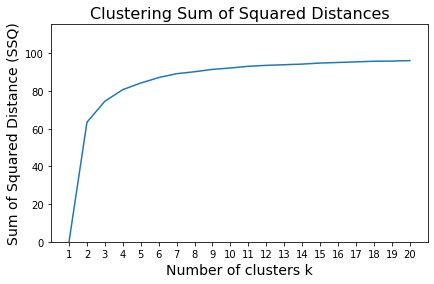

In [0]:
# Generate and plot the SSQ statistics
ssqs = ssq_statistics(hero_data, ks=range(1,20+1))
plot_ssq_statistics(ssqs)

**Fit and group heroes into 8 clusters**

In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8).fit(hero_data)
labels = kmeans.labels_

In [0]:
len(labels)

116

In [0]:
labels

array([5, 2, 0, 1, 6, 4, 6, 5, 1, 5, 5, 5, 1, 2, 1, 2, 1, 4, 1, 0, 4, 7,
       2, 1, 0, 6, 0, 6, 0, 6, 6, 4, 3, 7, 1, 6, 6, 1, 7, 4, 4, 1, 1, 7,
       5, 1, 5, 4, 0, 2, 1, 4, 1, 2, 1, 0, 2, 1, 6, 4, 6, 1, 6, 2, 0, 7,
       6, 2, 1, 0, 1, 5, 1, 6, 1, 4, 2, 6, 5, 4, 5, 0, 0, 0, 6, 0, 6, 4,
       6, 0, 2, 4, 5, 5, 2, 6, 1, 1, 6, 2, 2, 6, 2, 2, 1, 6, 2, 5, 2, 0,
       6, 3, 1, 2, 1, 6], dtype=int32)

In [0]:
# add cluster column to hero data
hero_data['cluster'] = labels

In [0]:
hero_data.head()

,kills,deaths,assists,last_hits,denies,gold_per_min,xp_per_min,gold_spent,hero_damage,tower_damage,level,cluster
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,
hero_id,,,,,,,,,,,,
1,6.823423,2.962883,5.501261,374.985225,16.980541,652.436757,657.051892,21718.535135,13676.197117,4531.254054,20.953514,5
2,6.532593,6.262192,8.362144,144.345727,2.922743,393.459440,436.087880,11826.640512,12353.809029,329.294302,17.274988,2
3,2.949980,6.332933,11.152461,25.117047,3.522209,247.899760,308.888956,7775.392157,6757.598639,228.969988,14.617647,0
4,8.385020,5.354008,9.347572,236.993563,16.308953,506.483909,529.891750,16953.282621,19034.640140,2047.499122,19.747221,1
5,2.803379,6.296534,12.744538,59.079231,1.074862,291.036411,333.853772,9306.788523,8957.451209,208.286630,15.554908,6


In [0]:
# create index id
ind = list(range(0, 116))

In [0]:
hero_clusters = hero_data[['cluster']]
hero_clusters['hero_id'] = hero_clusters.index
hero_clusters.insert(0, 'id', ind)
# hero_clusters.index.names = ['id']
hero_clusters.set_index(['id'], inplace = True)
hero_clusters.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,cluster,hero_id
,,
id,,
0,5,1
1,2,2
2,0,3
3,1,4
4,6,5


In [0]:
# summarize clustering labels
g = hero_clusters.groupby('cluster').agg({'hero_id': lambda x: list(x)})

g.head(9)

/usr/local/lib/python3.6/dist-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


,hero_id
cluster,
0,"[3, 20, 26, 28, 30, 50, 57, 66, 71, 83, 84, 85..."
1,"[4, 9, 13, 15, 17, 19, 25, 36, 39, 43, 44, 47,..."
2,"[2, 14, 16, 23, 51, 55, 58, 65, 69, 78, 92, 96..."
3,"[34, 113]"
4,"[6, 18, 21, 33, 41, 42, 49, 53, 61, 77, 81, 89..."
5,"[1, 8, 10, 11, 12, 46, 48, 73, 80, 82, 94, 95,..."
6,"[5, 7, 27, 29, 31, 32, 37, 38, 60, 62, 64, 68,..."
7,"[22, 35, 40, 45, 67]"


# **Win probability prediction based on team drafts**


In [0]:
player_data = df[["match_id", "player_slot", "kills", "deaths", "assists", "gold", "last_hits", "denies", "level", "radiant_win"]]
# get rid of NaN gold rows
player_data = player_data[np.isfinite(player_data['gold'])]

# add column to check win/lose
player_data["is_radiant"] = pd.to_numeric(player_data["player_slot"]) <= 4
player_data["is_win"] = (player_data["is_radiant"] == player_data["radiant_win"])

In [0]:
# check any NaN value
player_data.isnull().values.any()

False

In [0]:
player_data.head()

,match_id,player_slot,kills,deaths,assists,gold,last_hits,denies,level,radiant_win,is_radiant,is_win
69130,1384504402,2,1,6,4,1.0,166,25,16,False,True,False
69131,1384504402,3,3,4,3,1124.0,90,2,12,False,True,False
69132,1384504402,4,5,5,1,1.0,244,22,17,False,True,False
69133,1384504402,128,11,3,8,4393.0,136,7,19,False,False,True
69134,1384504402,129,1,3,11,1936.0,27,2,13,False,False,True


In [0]:
team_data = player_data.groupby(['match_id', 'is_radiant']).agg({"kills": ["sum"], "deaths": ["sum"], 
                                                                  "assists": ["sum"], "gold": ["sum"], "last_hits": ["sum"], 
                                                                  "denies": ["sum"], "level": ["sum"], "is_win":[lambda x: x.all()]})
# how many teams
len(team_data)

83878

In [0]:
team_data.head()

kills deaths assists  ... denies level   is_win
                        sum    sum     sum  ...    sum   sum <lambda>
match_id   is_radiant                       ...                      
1384504402 False         23     12      50  ...     33    85     True
           True          12     24      18  ...     53    68    False
1384528617 False          3     17      12  ...     24    53    False
           True          16      4      31  ...     47    65     True
1384560471 False         29     14      40  ...     48    90     True

[5 rows x 8 columns]

In [0]:
# Create training and testing datasets
from sklearn.model_selection import train_test_split
dt_data = team_data.iloc[:, :-1]
dt_data = dt_data.as_matrix()
dt_label = team_data['is_win']
dt_label = dt_label.as_matrix()
x_train, x_test, y_train, y_test = train_test_split(dt_data, dt_label, test_size=0.3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [0]:
# Use decision tree model to train the datasets
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Accuracy score is: ", accuracy_score(y_test, y_pred))
print("Precision score is: ", precision_score(y_test, y_pred))
print("Recall score is: ", recall_score(y_test, y_pred)) 
print("Confusion matrix is: \n", confusion_matrix(y_test, y_pred))

Accuracy score is:  0.9597838181529169
Precision score is:  0.9550544201706992
Recall score is:  0.9653343886030866
Confusion matrix is: 
 [[11955   574]
 [  438 12197]]


## **Decision Tree Model**

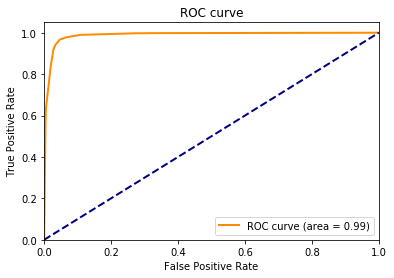

In [0]:
# Plot ROC curve
from sklearn.metrics import roc_curve, auc

y_score = clf.predict_proba(x_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

## **Logistic Regression Model**

In [0]:
# Use logistic regression model to train the datasets
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Accuracy score is: ", accuracy_score(y_test, y_pred))
print("Precision score is: ", precision_score(y_test, y_pred))
print("Recall score is: ", recall_score(y_test, y_pred)) 
print("Confusion matrix is: \n", confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy score is:  0.9695596884438086
Precision score is:  0.9690933523041657
Recall score is:  0.9703205381875742
Confusion matrix is: 
 [[12138   391]
 [  375 12260]]


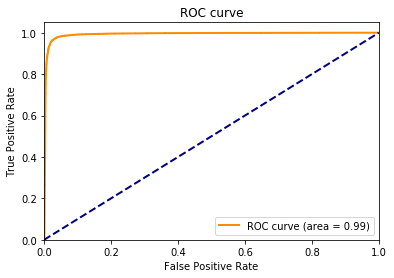

In [0]:
# Plot ROC curve
y_score = clf.predict_proba(x_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

## **K-Nearest Neighbor Model**

In [0]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Accuracy score is: ", accuracy_score(y_test, y_pred))
print("Precision score is: ", precision_score(y_test, y_pred))
print("Recall score is: ", recall_score(y_test, y_pred)) 
print("Confusion matrix is: \n", confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


Accuracy score is:  0.9308933396916229
Precision score is:  0.9303997471954495
Recall score is:  0.9320933913731698
Confusion matrix is: 
 [[11648   881]
 [  858 11777]]


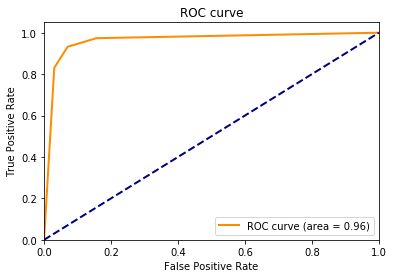

In [0]:
# Plot ROC curve
y_score = clf.predict_proba(x_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

## **Hero pick rate with win rate**

In [0]:
# number of heros
print(max(df['hero_id']))

121


In [0]:
heros = df['hero_id']
heros.value_counts()

86     15518
20     12279
7      11248
65     11036
74     10797
       ...  
82      1245
119     1112
120      931
113      467
105      206
Name: hero_id, Length: 116, dtype: int64

We can see from the value count, the most frequent used hero is number 86 and least frequent used hero is 105.




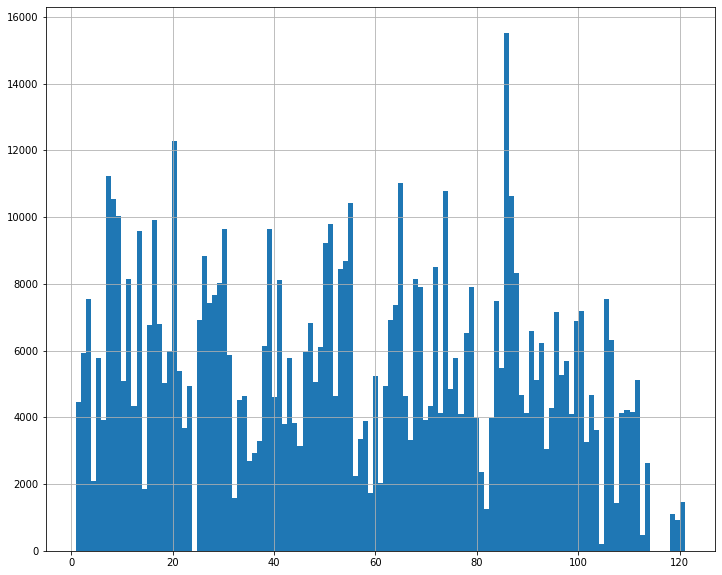

In [0]:
out = df.iloc[:, 3].hist(bins=121,figsize=(12, 10))

In [0]:
radiant_win = df[(df['radiant_win'] == True) & (df['player_slot'] < 5)]
radiant_win.head()
# match_radiant_win = df[((df['radiant_win'] == True) & (df['player_slot'] < 5)) & ((df['radiant_win'] == False) & (df['player_slot'] > 5))]


,match_id,account_id,player_slot,hero_id,item_0,item_1,item_2,item_3,item_4,item_5,backpack_0,backpack_1,backpack_2,kills,deaths,assists,leaver_status,gold,last_hits,denies,gold_per_min,xp_per_min,gold_spent,hero_damage,tower_damage,hero_healing,level,stuns,obs_placed,sen_placed,creeps_stacked,camps_stacked,rune_pickups,party_id,lane,lane_role,is_roaming,firstblood_claimed,teamfight_participation,towers_killed,roshans_killed,observers_placed,party_size,match_seq_num,radiant_win,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire,cluster,first_blood_time,lobby_type,human_players,leagueid,positive_votes,negative_votes,game_mode,engine,radiant_score,dire_score,radiant_team_id,dire_team_id,radiant_team_name,dire_team_name,radiant_team_complete,dire_team_complete,radiant_captain,dire_captain,version
0,1000018815,98134803,2,15,119,110,46,108,116,63,0,0,0,8,5,12,0,NaN,281,36,547,623,NaN,NaN,NaN,NaN,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,895116683,True,1414947750,2764,1972,0,63,32,131,38,1,10,2051,48,8,2,0,0,0,NaN,1839396.0,NaN,NaN,NaN,1.0,93552791.0,87565571.0,20.0
3,1000018815,191422410,1,30,36,214,108,116,46,0,0,0,0,8,8,5,0,NaN,85,2,326,385,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,895116683,True,1414947750,2764,1972,0,63,32,131,38,1,10,2051,48,8,2,0,0,0,NaN,1839396.0,NaN,NaN,NaN,1.0,93552791.0,87565571.0,20.0
5,1000018815,86785083,4,88,41,46,1,104,180,100,0,0,0,5,5,14,0,NaN,57,0,284,411,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,895116683,True,1414947750,2764,1972,0,63,32,131,38,1,10,2051,48,8,2,0,0,0,NaN,1839396.0,NaN,NaN,NaN,1.0,93552791.0,87565571.0,20.0
8,1000018815,123051238,3,93,110,1,160,208,63,139,0,0,0,28,2,10,0,NaN,299,16,783,706,NaN,NaN,NaN,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,895116683,True,1414947750,2764,1972,0,63,32,131,38,1,10,2051,48,8,2,0,0,0,NaN,1839396.0,NaN,NaN,NaN,1.0,93552791.0,87565571.0,20.0
9,1000018815,93552791,0,84,92,102,23,214,0,36,0,0,0,5,10,17,0,NaN,33,3,262,363,NaN,NaN,NaN,NaN,17,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,895116683,True,1414947750,2764,1972,0,63,32,131,38,1,10,2051,48,8,2,0,0,0,NaN,1839396.0,NaN,NaN,NaN,1.0,93552791.0,87565571.0,20.0


In [0]:
heros_radiant_win = radiant_win['hero_id']
heros_radiant_win.value_counts()

86     4018
20     3154
7      2927
65     2899
9      2806
       ... 
82      348
120     281
119     270
113     117
105      53
Name: hero_id, Length: 116, dtype: int64

In [0]:
dire_win = df[(df['radiant_win'] == False) & (df['player_slot'] > 5)]
dire_win.head()

,match_id,account_id,player_slot,hero_id,item_0,item_1,item_2,item_3,item_4,item_5,backpack_0,backpack_1,backpack_2,kills,deaths,assists,leaver_status,gold,last_hits,denies,gold_per_min,xp_per_min,gold_spent,hero_damage,tower_damage,hero_healing,level,stuns,obs_placed,sen_placed,creeps_stacked,camps_stacked,rune_pickups,party_id,lane,lane_role,is_roaming,firstblood_claimed,teamfight_participation,towers_killed,roshans_killed,observers_placed,party_size,match_seq_num,radiant_win,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire,cluster,first_blood_time,lobby_type,human_players,leagueid,positive_votes,negative_votes,game_mode,engine,radiant_score,dire_score,radiant_team_id,dire_team_id,radiant_team_name,dire_team_name,radiant_team_complete,dire_team_complete,radiant_captain,dire_captain,version
11,1000020264,97073485,128,42,36,63,170,151,172,46,0,0,0,4,9,15,0,NaN,53,4,371,501,NaN,NaN,NaN,NaN,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,895081113,False,1414947775,1875,0,2047,0,63,134,74,1,10,2061,3,0,2,0,0,0,1564466.0,1532777.0,NaN,NaN,0.0,0.0,160970445.0,97073485.0,20.0
12,1000020264,86748852,130,59,50,151,1,172,92,46,0,0,0,17,14,9,0,NaN,40,13,451,371,NaN,NaN,NaN,NaN,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,895081113,False,1414947775,1875,0,2047,0,63,134,74,1,10,2061,3,0,2,0,0,0,1564466.0,1532777.0,NaN,NaN,0.0,0.0,160970445.0,97073485.0,20.0
13,1000020264,49842719,132,64,48,151,172,0,0,0,0,0,0,11,8,22,0,NaN,87,4,468,551,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,895081113,False,1414947775,1875,0,2047,0,63,134,74,1,10,2061,3,0,2,0,0,0,1564466.0,1532777.0,NaN,NaN,0.0,0.0,160970445.0,97073485.0,20.0
17,1000020264,91480675,131,104,63,1,151,116,112,0,0,0,0,14,5,10,0,NaN,160,6,631,700,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,895081113,False,1414947775,1875,0,2047,0,63,134,74,1,10,2061,3,0,2,0,0,0,1564466.0,1532777.0,NaN,NaN,0.0,0.0,160970445.0,97073485.0,20.0
19,1000020264,96191708,129,9,63,151,42,0,151,34,0,0,0,10,11,21,0,NaN,21,1,375,406,NaN,NaN,NaN,NaN,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,895081113,False,1414947775,1875,0,2047,0,63,134,74,1,10,2061,3,0,2,0,0,0,1564466.0,1532777.0,NaN,NaN,0.0,0.0,160970445.0,97073485.0,20.0


In [0]:
heros_dire_win = dire_win['hero_id']
heros_dire_win.value_counts()

86     3812
20     3194
65     2727
8      2654
74     2635
       ... 
82      271
119     263
120     207
113     111
105      48
Name: hero_id, Length: 116, dtype: int64

In [0]:
df_win_match = pd.concat([radiant_win, dire_win], ignore_index=True)
df_win_match.head()

,match_id,account_id,player_slot,hero_id,item_0,item_1,item_2,item_3,item_4,item_5,backpack_0,backpack_1,backpack_2,kills,deaths,assists,leaver_status,gold,last_hits,denies,gold_per_min,xp_per_min,gold_spent,hero_damage,tower_damage,hero_healing,level,stuns,obs_placed,sen_placed,creeps_stacked,camps_stacked,rune_pickups,party_id,lane,lane_role,is_roaming,firstblood_claimed,teamfight_participation,towers_killed,roshans_killed,observers_placed,party_size,match_seq_num,radiant_win,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire,cluster,first_blood_time,lobby_type,human_players,leagueid,positive_votes,negative_votes,game_mode,engine,radiant_score,dire_score,radiant_team_id,dire_team_id,radiant_team_name,dire_team_name,radiant_team_complete,dire_team_complete,radiant_captain,dire_captain,version
0,1000018815,98134803,2,15,119,110,46,108,116,63,0,0,0,8,5,12,0,NaN,281,36,547,623,NaN,NaN,NaN,NaN,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,895116683,True,1414947750,2764,1972,0,63,32,131,38,1,10,2051,48,8,2,0,0,0,NaN,1839396.0,NaN,NaN,NaN,1.0,93552791.0,87565571.0,20.0
1,1000018815,191422410,1,30,36,214,108,116,46,0,0,0,0,8,8,5,0,NaN,85,2,326,385,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,895116683,True,1414947750,2764,1972,0,63,32,131,38,1,10,2051,48,8,2,0,0,0,NaN,1839396.0,NaN,NaN,NaN,1.0,93552791.0,87565571.0,20.0
2,1000018815,86785083,4,88,41,46,1,104,180,100,0,0,0,5,5,14,0,NaN,57,0,284,411,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,895116683,True,1414947750,2764,1972,0,63,32,131,38,1,10,2051,48,8,2,0,0,0,NaN,1839396.0,NaN,NaN,NaN,1.0,93552791.0,87565571.0,20.0
3,1000018815,123051238,3,93,110,1,160,208,63,139,0,0,0,28,2,10,0,NaN,299,16,783,706,NaN,NaN,NaN,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,895116683,True,1414947750,2764,1972,0,63,32,131,38,1,10,2051,48,8,2,0,0,0,NaN,1839396.0,NaN,NaN,NaN,1.0,93552791.0,87565571.0,20.0
4,1000018815,93552791,0,84,92,102,23,214,0,36,0,0,0,5,10,17,0,NaN,33,3,262,363,NaN,NaN,NaN,NaN,17,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,895116683,True,1414947750,2764,1972,0,63,32,131,38,1,10,2051,48,8,2,0,0,0,NaN,1839396.0,NaN,NaN,NaN,1.0,93552791.0,87565571.0,20.0


In [0]:
heros_win = df_win_match['hero_id']
heros_win.value_counts()

86     7830
20     6348
65     5626
7      5508
8      5434
       ... 
82      619
119     533
120     488
113     228
105     101
Name: hero_id, Length: 116, dtype: int64

In [0]:
# Hero pick rate and win rate table
group_by_match = df.groupby('match_id').size()
print(group_by_match.shape)

(66009,)


In [0]:
hero_data = df[["match_id", "hero_id", "player_slot", "radiant_win"]]
number_of_matches = 66009
# add column to check win/lose
hero_data["is_radiant"] = pd.to_numeric(hero_data["player_slot"]) <= 4
hero_data["is_win"] = (hero_data["is_radiant"] == hero_data["radiant_win"])
hero_data.head()
# hero_aggregation_data = hero_data.groupby(['hero_id']).agg({"hero_pick", "is_win"})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,match_id,hero_id,player_slot,radiant_win,is_radiant,is_win
0,1000018815,15,2,True,True,True
1,1000018815,86,130,True,False,False
2,1000018815,78,129,True,False,False
3,1000018815,30,1,True,True,True
4,1000018815,67,131,True,False,False


In [0]:
# Prepare data with hero pick rate and win rate
mid_table = hero_data.groupby('hero_id').agg({"is_radiant": [lambda x: float((x.sum() + (x == False).sum()) * 10 / len(hero_data.index))],
                                          "is_win": [lambda x: float(x.sum() / (x.sum() + (x == False).sum()))]})
pick_win_rate = mid_table.rename(columns={'is_radiant': 'pick_rate', 'is_win': 'win_rate'})
pick_win_rate.head(5)

,pick_rate,win_rate
,<lambda>,<lambda>
hero_id,,
1,0.067370,0.498313
2,0.089609,0.473035
3,0.114378,0.528609
4,0.031708,0.489250
5,0.087730,0.528579


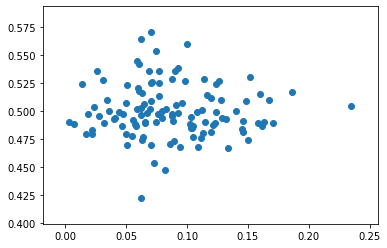

In [0]:
# Plot between pick rate and win rate
import matplotlib.pyplot as plt
xs=pick_win_rate['pick_rate']
ys=pick_win_rate['win_rate']
plt.scatter(xs,ys)

In [0]:
# Pearson's r
corr=pick_win_rate.corr() 
print(corr)

                   pick_rate  win_rate
                    <lambda>  <lambda>
pick_rate <lambda>  1.000000 -0.026916
win_rate  <lambda> -0.026916  1.000000


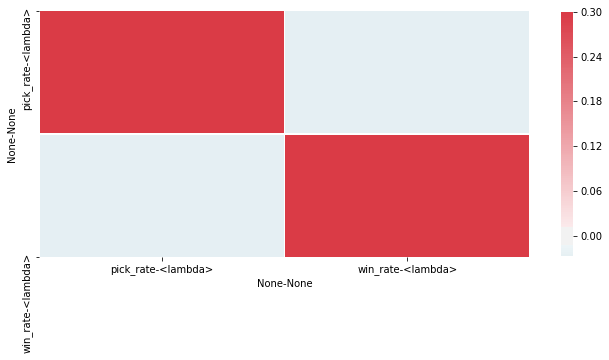

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# **Relationship between first blood and match outcome**

In [0]:
player_data = df[["firstblood_claimed", "first_blood_time", "match_id", "player_slot", "radiant_win"]]
# get rid of NaN firstblood_claimed rows
player_data = player_data[np.isfinite(player_data['firstblood_claimed'])]
# add column to check win/lose
player_data["is_radiant"] = pd.to_numeric(player_data["player_slot"]) <= 4
player_data["is_win"] = (player_data["is_radiant"] == player_data["radiant_win"])
team_data = player_data.groupby(['match_id', 'is_radiant']).agg({"firstblood_claimed": ["max"], "first_blood_time": ["mean"], 
                                                                  "is_win":[lambda x: x.all()]})

In [0]:
player_data.head()

,firstblood_claimed,first_blood_time,match_id,player_slot,radiant_win,is_radiant,is_win
9,0.0,38,1000018815,0,True,True,True
16,0.0,74,1000020264,0,False,True,False
25,0.0,165,1000025803,0,False,True,False
36,0.0,64,1000026645,0,True,True,True
49,0.0,222,1000038577,0,True,True,True


In [0]:
team_data.head()

,,firstblood_claimed,first_blood_time,is_win
,,max,mean,<lambda>
match_id,is_radiant,,,
18355350,True,0.0,139,True
19009163,True,0.0,206,False
19249598,True,0.0,403,False
19254348,True,0.0,54,True
19266829,True,0.0,62,False


In [0]:
# Create training and testing datasets
from sklearn.model_selection import train_test_split
dt_data = team_data.iloc[:, :-1]
dt_data = dt_data.as_matrix()
dt_label = team_data['is_win']
dt_label = dt_label.as_matrix()
x_train, x_test, y_train, y_test = train_test_split(dt_data, dt_label, test_size=0.2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [0]:
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Accuracy score is: ", accuracy_score(y_test, y_pred))
print("Precision score is: ", precision_score(y_test, y_pred))
print("Recall score is: ", recall_score(y_test, y_pred)) 
print("Confusion matrix is: \n", confusion_matrix(y_test, y_pred))

Accuracy score is:  0.5468085106382978
Precision score is:  0.5787131466716113
Recall score is:  0.385737238907428
Confusion matrix is: 
 [[5617 2272]
 [4970 3121]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


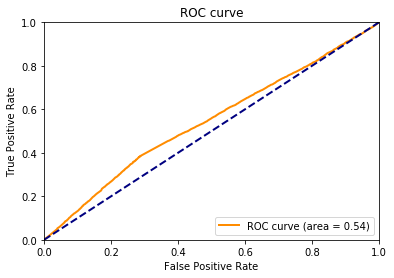

In [0]:
from sklearn.metrics import roc_curve, auc

y_score = clf.predict_proba(x_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

We can see from the metric and ROC curve above, the relationship between first blood (`firstblood_claimed` and `first_blood_time`) and match result is fairly weak. It is not reliable to predict the match result